# 🧹 **Data Cleaning & Feature Engineering** — Housing Prices in India

---

### 🔗 **Notebook Context**
This notebook is the **second stage** of the *Housing Prices in India* project.  
In the previous notebook, we performed an **Exploratory Data Analysis (EDA)** to understand data distributions, relationships, and patterns.  

Here, we’ll implement the **data cleaning and feature engineering** processes guided by insights from the EDA.  
The cleaned dataset will serve as the foundation for the machine learning model in the next stage.

---

## 🧭 **Objectives**

1. Load and review the raw dataset  
2. Implement data cleaning strategies identified during EDA  
3. Handle missing values, duplicates, and inconsistent entries  
4. Engineer meaningful features for improved model performance  
5. Save the cleaned and transformed dataset for modeling  

---

## 📦 **1. Setup & Data Loading**
- Import relevant libraries  
- Load dataset  
- Verify data integrity (shape, columns, dtypes)  

In [20]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from IPython.display import display
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

MODULE_PATH = os.path.abspath(os.path.join("..", "src"))
if MODULE_PATH not in sys.path:
    sys.path.insert(0, MODULE_PATH)

from feature_engineering.address import get_address_from_coordinates 
from analysis.multivariate import Multivariate
from feature_engineering.outliers import cap_outliers_iqr

In [21]:
df = pd.read_csv('../data/train.csv')
display(df.head())
display(df.info())
display(df.shape)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   POSTED_BY              29451 non-null  object 
 1   UNDER_CONSTRUCTION     29451 non-null  int64  
 2   RERA                   29451 non-null  int64  
 3   BHK_NO.                29451 non-null  int64  
 4   BHK_OR_RK              29451 non-null  object 
 5   SQUARE_FT              29451 non-null  float64
 6   READY_TO_MOVE          29451 non-null  int64  
 7   RESALE                 29451 non-null  int64  
 8   ADDRESS                29451 non-null  object 
 9   LONGITUDE              29451 non-null  float64
 10  LATITUDE               29451 non-null  float64
 11  TARGET(PRICE_IN_LACS)  29451 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.7+ MB


None

(29451, 12)

Now, the dataset remains in the right format as expected.
## Data Cleaning
### **Rename column names**
The first step is to rename the column, set the names to lower case, then, set all binary values to their appropriate values so that we can use Label encoding on them.

In [22]:
# Rename columns to lower case
try:
    df.rename(columns={'TARGET(PRICE_IN_LACS)': 'PRICE'})
    df.rename(columns=lambda x: x.lower(), inplace=True)

    df.rename(columns={
            'rera': 'rera_approved',
            'bhk_no.': 'num_of_rooms',
            'square_ft': 'total_area',
            'target(price_in_lacs)': 'price'
        }, inplace=True)
except Exception as e:
    print(f"Error renaming columns: {e}")

In [23]:
pct_duplicated = 100 * df.duplicated().sum() / len(df)
print(f"Percentage of duplicated rows: {pct_duplicated:.2f}%")

Percentage of duplicated rows: 1.36%


### **Handle Duplicates**

Now, the next step is to drop duplicate data. Though, this is allowed it is allowed in the real-estate industry that we can have multiple, identical houses in the same compound sharing exactyly the same attributes including prices. 

In our case, the house numbers or block numbers are not provided, so duplicates are allowed, for machine learning modelling, only one is enough to provide the required information.

In addition, since only **1.36%** of the data has duplicates, we can drop the duplicates.

In [24]:
df.drop_duplicates(inplace=True)
assert df.duplicated().sum() == 0

### **Handle Binary Features**
The binary features which are already encoded as integers need to be set to their semantic meaning so that Label Encoder can appropriately work on them during data preparation for modelling.



In [25]:
df['rera_approved'] = df['rera_approved'].map({1: 'Yes', 0: 'No'})
df['ready_to_move'] = df['ready_to_move'].map({1: 'Yes', 0: 'No'})
df['resale'] = df['resale'].map({1: 'Yes', 0: 'No'})
df['under_construction'] = df['under_construction'].map({1: 'Yes', 0: 'No'})

In [26]:
df.head()

,posted_by,under_construction,rera_approved,num_of_rooms,bhk_or_rk,total_area,ready_to_move,resale,address,longitude,latitude,price
0,Owner,No,No,2,BHK,1300.236407,Yes,Yes,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,No,No,2,BHK,1275.000000,Yes,Yes,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,No,No,2,BHK,933.159722,Yes,Yes,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,No,Yes,2,BHK,929.921143,Yes,Yes,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,Yes,No,2,BHK,999.009247,No,Yes,"New Town,Kolkata",22.592200,88.484911,60.5


### **Handle Outliers**
In the real-estate industry, we need to know precisely what data point does not make sense, especially for numerical columns.

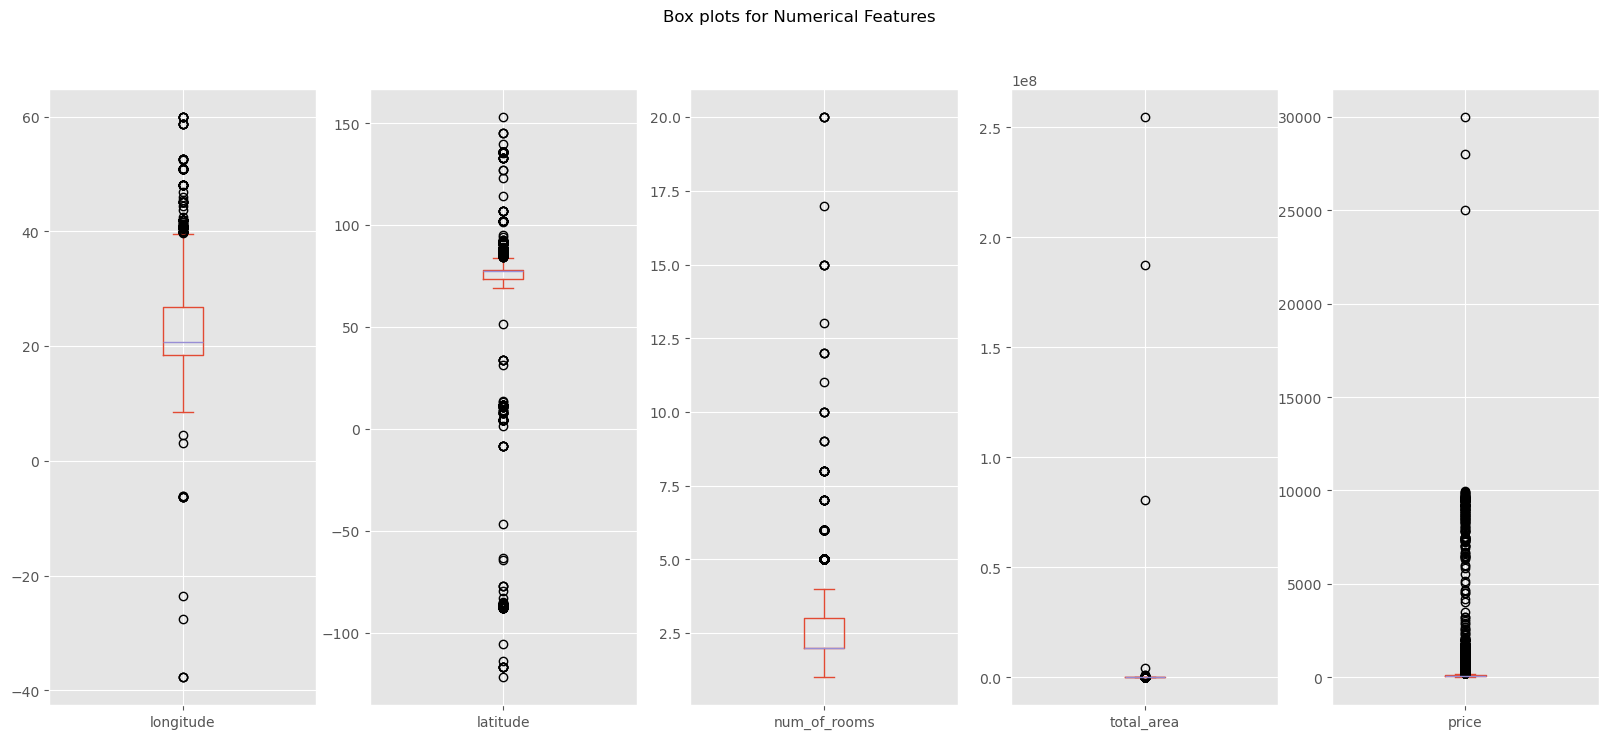

In [27]:
df[['longitude', 'latitude', 'num_of_rooms', 'total_area', 'price']]\
    .plot(kind='box', subplots=True, layout=(1, 5), figsize=(20, 8))
plt.suptitle('Box plots for Numerical Features')
plt.show()

In this section, I handled the outliers by capping them to a value. The values being 1 - 1.5 of the inter-quartile range for the lower bound and 1 + 1.5 of the inter-quartile range for the upper bound.

<div class="alert alert-warning">
<code>geopy</code> fails for this project.
</div>

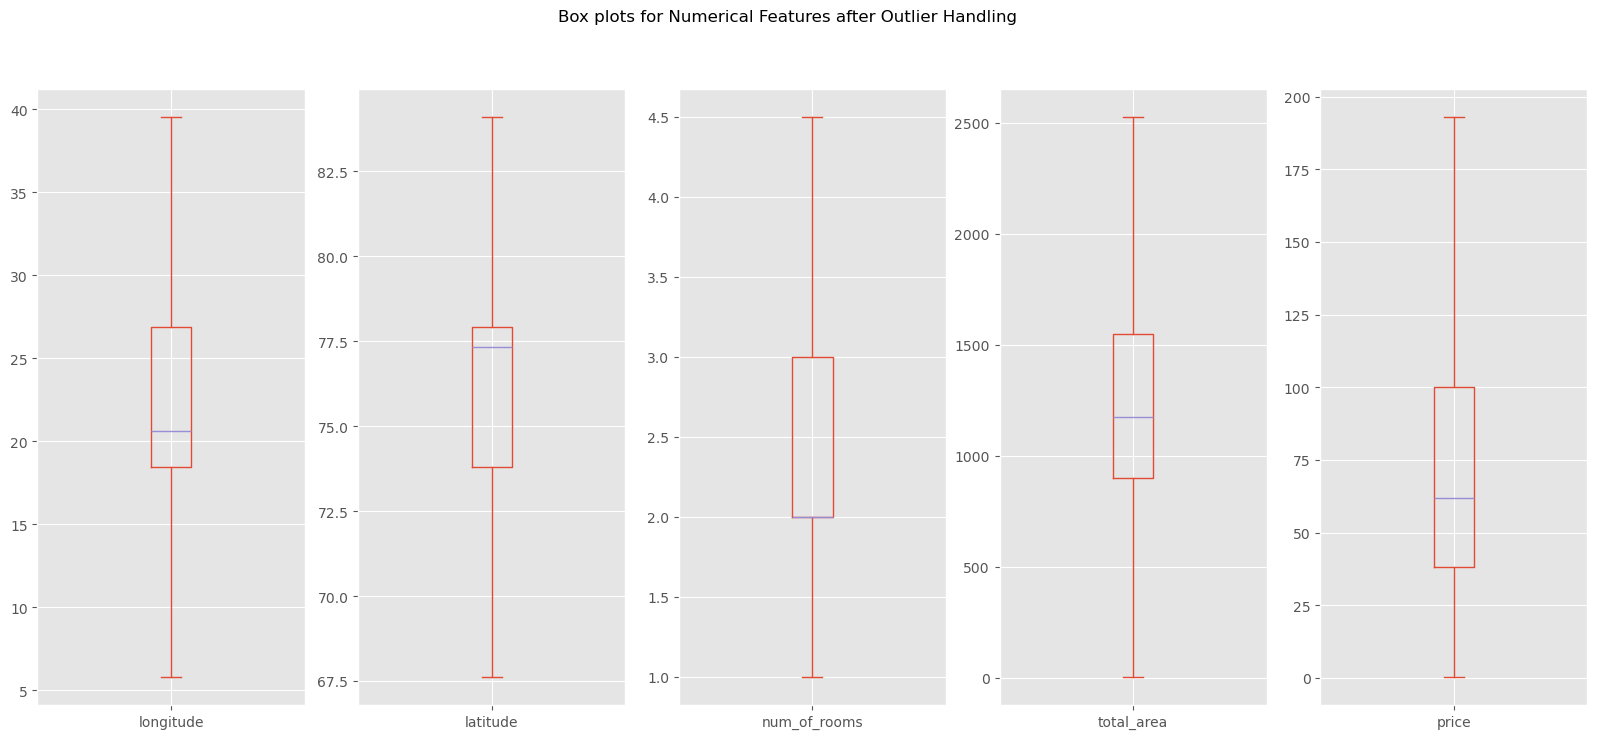

In [28]:
for col in ['longitude', 'latitude', 'num_of_rooms', 'total_area', 'price']:
    df = cap_outliers_iqr(df, col)
df[['longitude', 'latitude', 'num_of_rooms', 'total_area', 'price']]\
    .plot(kind='box', subplots=True, layout=(1, 5), figsize=(20, 8))
plt.suptitle('Box plots for Numerical Features after Outlier Handling')
plt.show()

In [29]:
df.drop(columns=['address'], inplace=True)

Since computing resources are limited, I drop the address completely, using latitude and longituede information.

## **Feature Engineering**
Looking at the insight gained in the bivariate analyssis from exploring the data, the following columns needs to be created.

i.   Average price per unit area

ii.  Average price per room

iii.  Area covered per room

In [30]:
df['avg_price_per_unit_area'] = df['price'] / df['total_area']
df['avg_price_per_room'] = df['price'] / df['num_of_rooms']
df['area_per_room'] = df['total_area'] / df['num_of_rooms']

Now, I need to check for colinearity, among the numerical variables. Of course, some variables will be dropped.

<Figure size 1000x800 with 0 Axes>

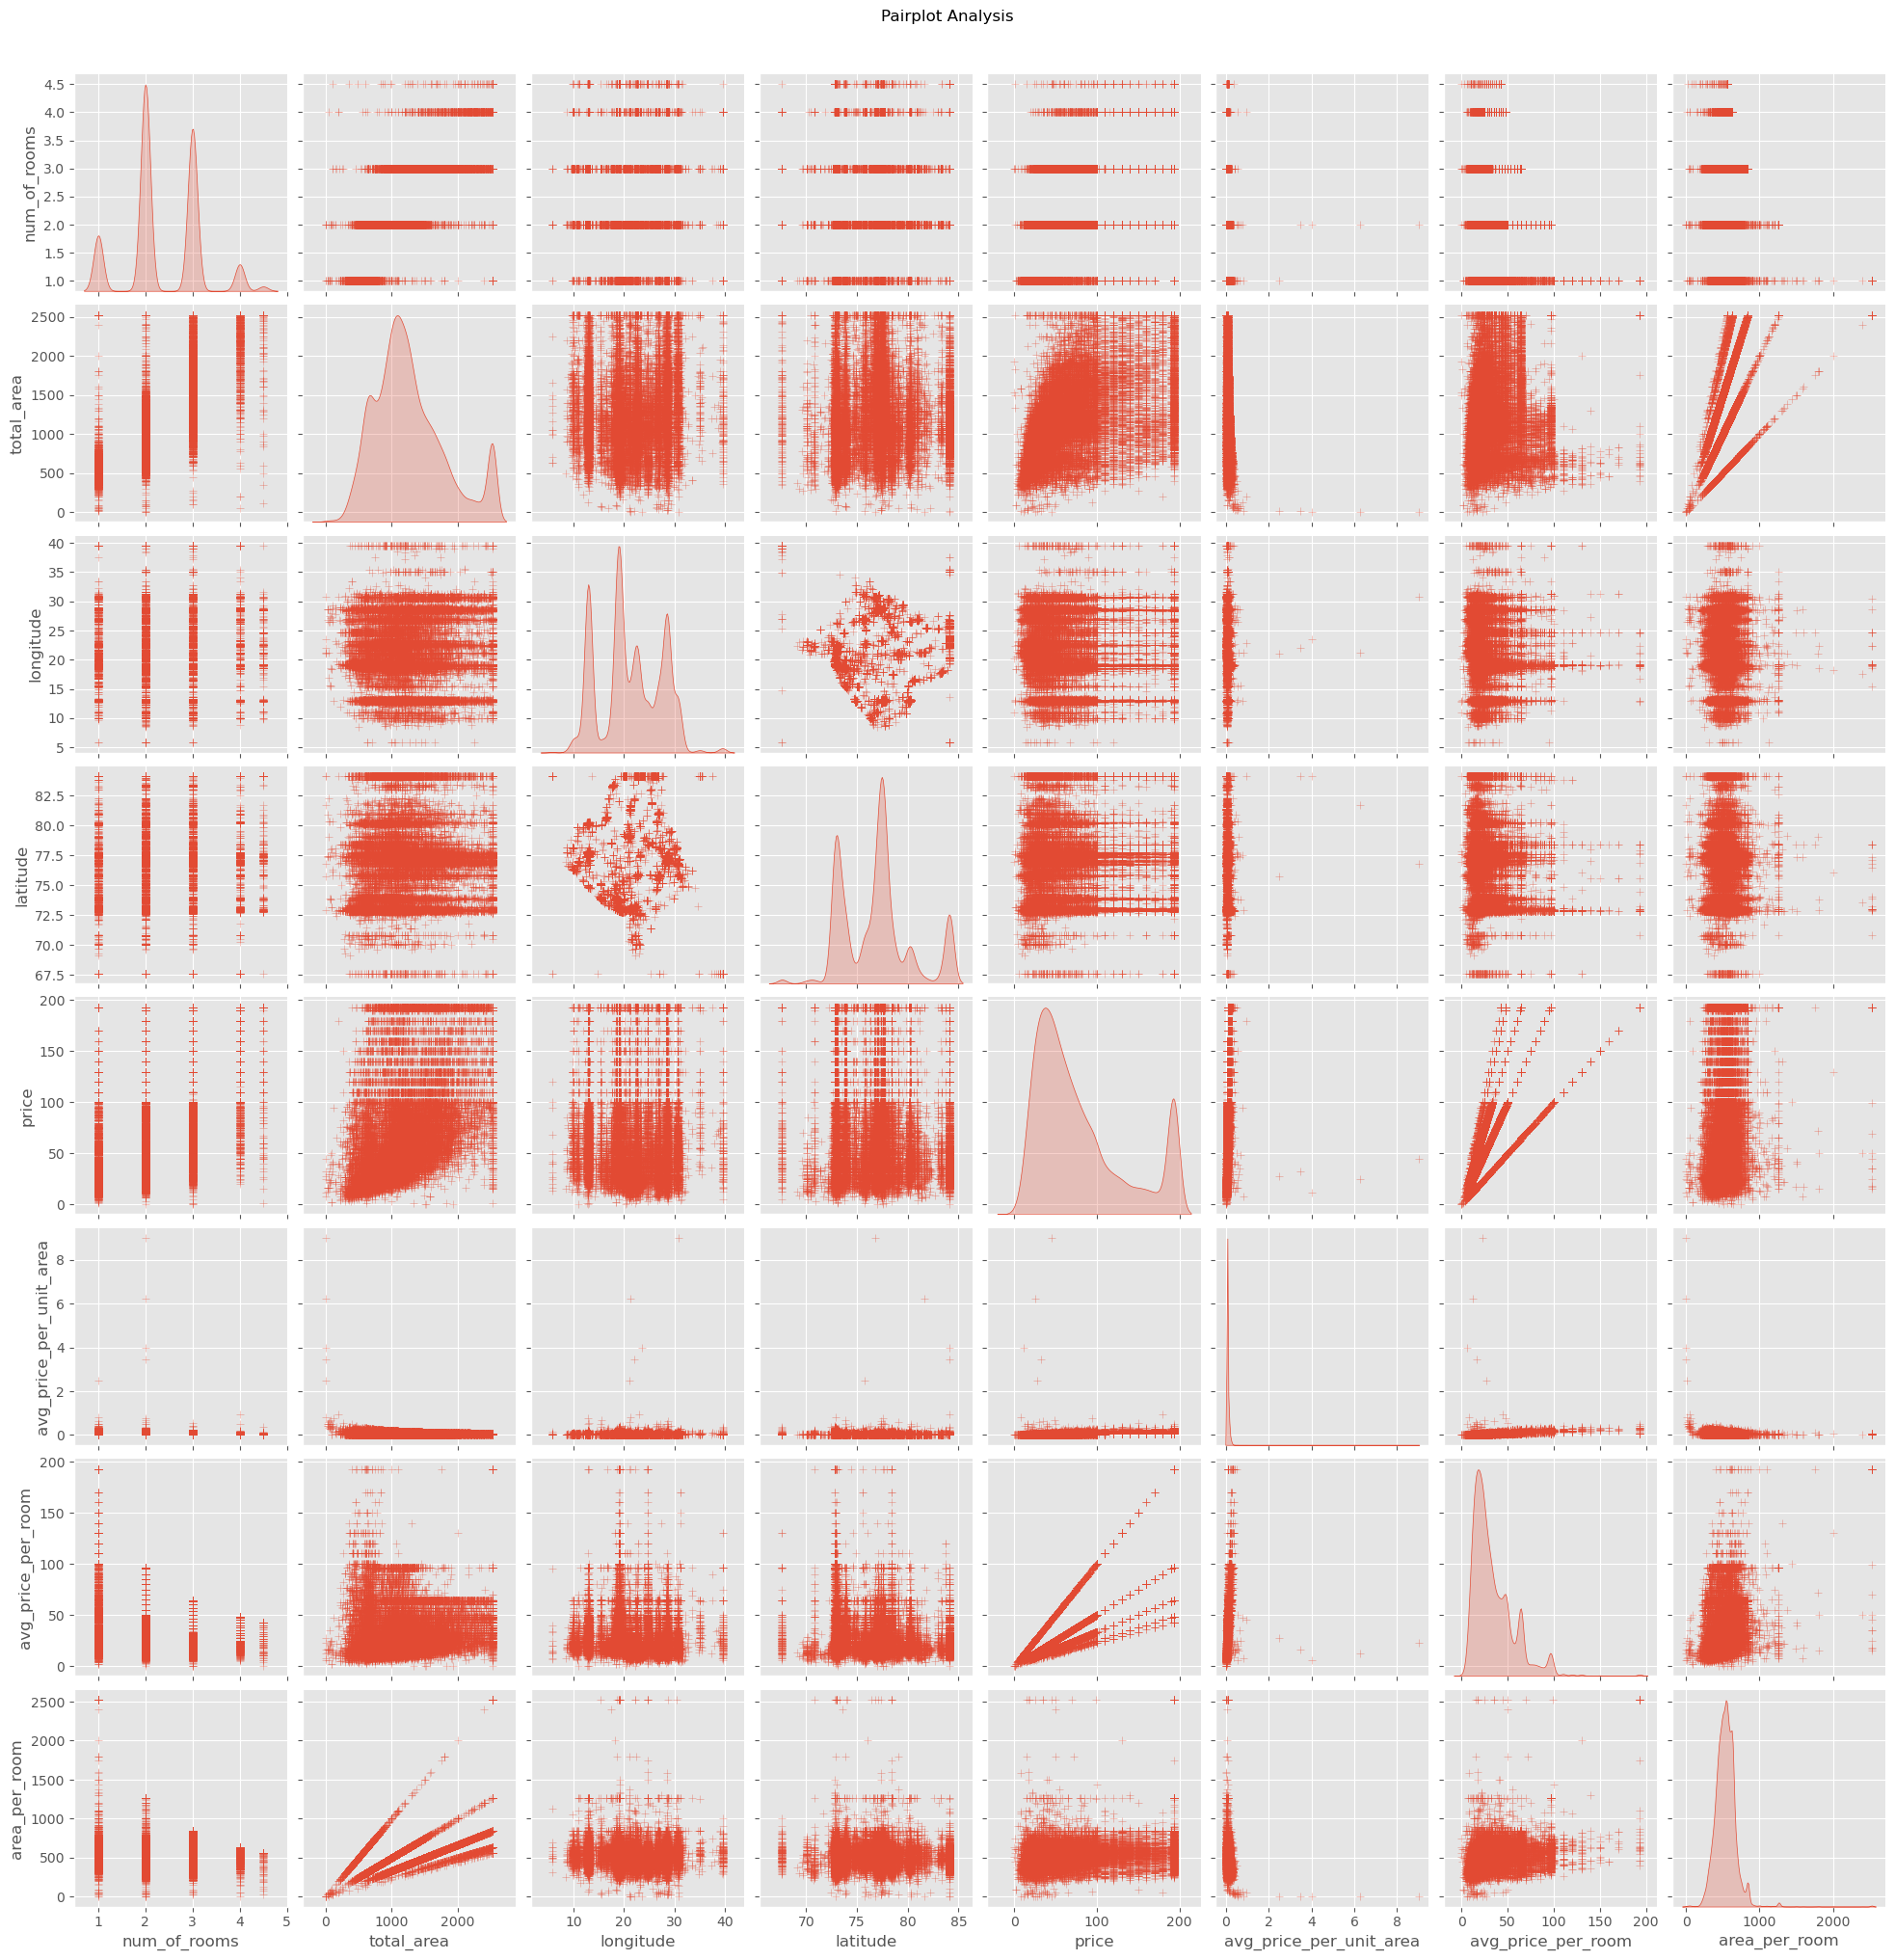

In [31]:
multivariate = Multivariate(df)
multivariate.pairplot_analysis()

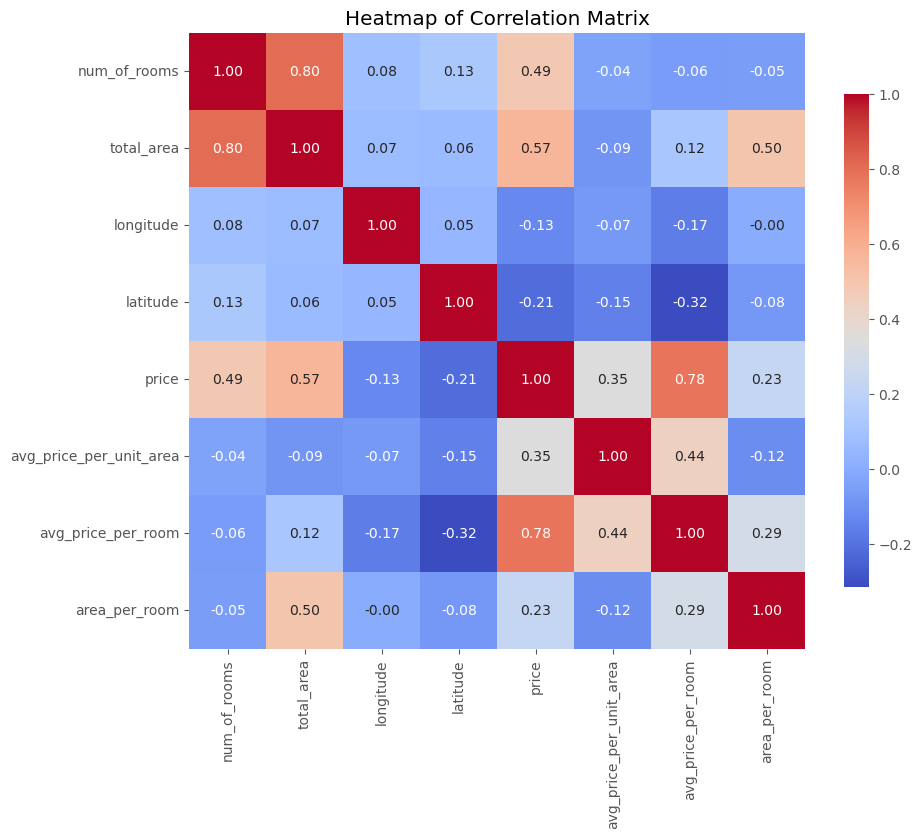

In [32]:
multivariate.heatmap_analysis()

Since `total_area` is strongly correlated with `area_per_room`, this is **multicolinearity**. I drop one of them. I drom the `total_area` feature.

In [33]:
df.drop(columns=['total_area'], inplace=True)

### **Neighborhood**
Use the `lat/lon` coordinates to create a neighborhood feature.

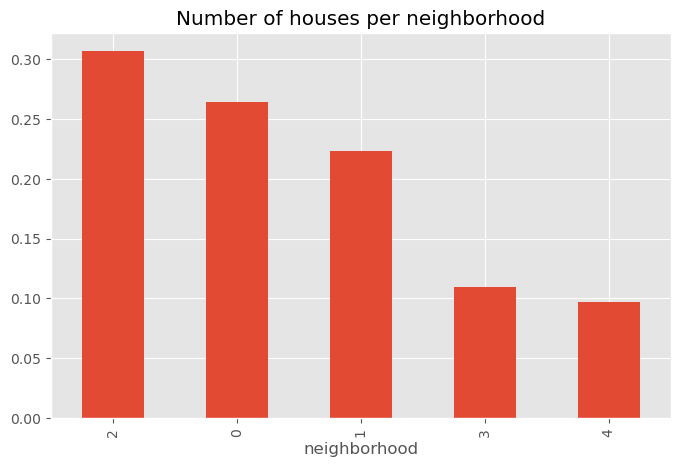

In [34]:
kmean = KMeans(n_clusters=5, random_state=42)
df['neighborhood'] = kmean.fit_predict(df[['latitude', 'longitude']])
df['neighborhood'] = df['neighborhood'].astype('category')
df['neighborhood'].value_counts(normalize=True).plot(kind='bar', title='Number of houses per neighborhood', figsize=(8, 5))
plt.show()


In [35]:
df.to_csv('../data/cleaned-feature-engineered-data.csv', index=False)

At this point, I can save my data. In the next notebook, we will train the models.

---

<p align="center">
  <b>👨🏽‍💻 Authored by:</b><br>
  <a href="https://github.com/mobadara">
    <img src="https://img.shields.io/badge/GitHub-mobadara-black?logo=github" alt="GitHub"/>
  </a>
  <a href="https://linkedin.com/in/obadara-m">
    <img src="https://img.shields.io/badge/LinkedIn-Muyiwa%20Obadara-blue?logo=linkedin" alt="LinkedIn"/>
  </a>
  <a href="https://x.com/m_obadara">
    <img src="https://img.shields.io/badge/Twitter-@m__obadara-1DA1F2?logo=x" alt="Twitter"/>
  </a>
</p>

<p align="center">
  <i>Exploring the intersection of Data Science, AI, and real-world impact — one dataset at a time.</i>
</p>

---
